In [1]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import render_rays
from models.nerf import Embedding, NeRF

from datasets.blender import BlenderDataset

dataset = BlenderDataset('/home/ubuntu/data/nerf_example_data/nerf_synthetic/lego/', 'val',
                         img_wh=(400, 400))

In [2]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = 'ckpts/exp/epoch=00.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda()
nerf_fine.cuda();

In [4]:
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64

def decode_batch(batch):
    rays = batch['rays'] # (B, 8)
    rgbs = batch['rgbs'] # (B, 3)
    return rays, rgbs

@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    chunk = 1024*32
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        False,
                        0,
                        0,
                        N_importance,
                        chunk) # chunk size is effective in val mode

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [13]:
rays, rgbs = decode_batch(dataset[0])
rays = rays.cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

6.275297164916992


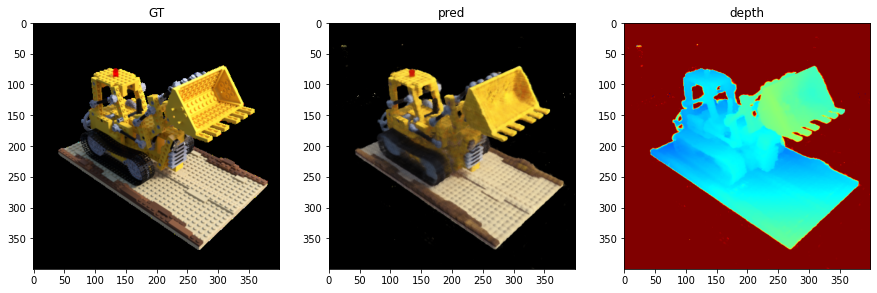

In [14]:
plt.subplots(figsize=(15, 10))
plt.subplot(131)
plt.title('GT')
plt.imshow(rgbs.view(400, 400, 3))
plt.subplot(132)
plt.title('pred')
plt.imshow(results['rgb_fine'].view(400, 400, 3).cpu().numpy())
plt.subplot(133)
plt.title('depth')
plt.imshow(visualize_depth(results['depth_fine'].view(400,400)).permute(1,2,0))